---
title: "Jupyter Kernels Made Simple: Connecting Your Virtual Environments to Notebooks"
author: "Gaurav Adlakha"
date: "2025-04-10"
categories: [python, jupyter, virtual-environments, data-science]
image: "jupyter-kernels-thumbnail.jpg"
description: "Learn how to properly connect your Python virtual environments to Jupyter notebooks using kernels to avoid package import errors."
toc: true
toc-depth: 3
format:
  html:
    code-fold: true
    code-tools: true
    highlight-style: github
    fig-width: 8
    fig-height: 6
    anchor-sections: true
    smooth-scroll: true
    link-external-newwindow: true
execute:
  echo: true
  warning: false
---


| Metric | Intuitive Explanation | When to Use | When to Avoid | Best for Which Datasets | Why It's Better |
|--------|----------------------|-------------|--------------|------------------------|----------------|
| Accuracy | Fraction of predictions your model got right | Simple classification with balanced classes | Imbalanced datasets | Balanced datasets | Simple, intuitive, but misleading with imbalance |
| F1 Score | Harmonic mean of precision and recall | When false positives and false negatives are equally important | When costs of errors differ significantly | Imbalanced datasets | Balances precision and recall without being influenced by true negatives |
| F-beta | Weighted harmonic mean allowing control of precision vs recall importance | When one type of error is more costly | When you want a simple metric | Imbalanced datasets | Allows customizing the importance of precision vs recall (β<1 favors precision, β>1 favors recall) |
| Precision | "When model predicts yes, how often is it correct?" | When false positives are costly | When false negatives are costly | Imbalanced datasets where positive predictions must be trustworthy | Focuses only on quality of positive predictions |
| Recall | "What fraction of actual positives did the model catch?" | When false negatives are costly | When false positives are costly | Imbalanced datasets where finding all positives is critical | Focuses only on finding all positive cases |
| Top-k Accuracy | Fraction of examples where correct label is among top k predictions | Multi-class problems with similar classes | Binary classification | Large number of classes | Gives credit when model is "close" but not perfect |
| Average Precision (AP) | Average of precision values at each true positive | Ranking quality evaluation, rare event detection | When binary classification is needed | Imbalanced datasets with rare positive class | Evaluates full ranking quality without threshold, focuses on positive class |
| ROC AUC | Probability model ranks a random positive higher than a random negative | Comparing models, threshold-independent evaluation | Highly imbalanced datasets | Moderately imbalanced datasets | Independent of threshold, evaluates ranking performance |
| PR AUC | Area under precision-recall curve | Imbalanced datasets where positive class is of interest | Balanced datasets | Highly imbalanced datasets | Focuses on positive class performance without being affected by large number of negatives |
| Balanced Accuracy | Average of positive and negative recall | Imbalanced datasets | When classes have very different importance | Imbalanced datasets | Gives equal weight to each class regardless of frequency |
| Brier Score | Measures accuracy of probabilistic predictions | Calibration assessment, probabilistic forecasting | When only interested in final class, not probability | Probabilistic predictions requiring calibration | Evaluates quality of probability estimates, not just final prediction |
| Cohen's Kappa | Agreement beyond chance between raters/classifiers | Measuring inter-rater reliability, accounting for chance | Highly imbalanced datasets | Moderate imbalance with multiple raters | Accounts for agreement by chance, good for comparing annotators |
| Hamming Loss | Fraction of incorrect label predictions in multi-label classification | Multi-label classification | Single-label classification | Multi-label datasets | Evaluates each label independently, appropriate when labels are independent |
| Jaccard Index | Ratio of common elements to all elements in two sets | Multi-label, set similarity, recommendations | When true negatives matter | Multi-label classification, set comparison | Focuses on overlap quality, ignores true negatives |
| Matthews Correlation (MCC) | Correlation between predicted and actual labels | Binary classification with imbalance | When one class matters more | Imbalanced datasets | Works well with imbalance, considers all four confusion matrix values |


In [ ]:
from utils import *


# Experiment with diffrent  imbalance_ratios

   ratio  pos_pct       acc    pr_auc   roc_auc
0   0.50     50.0  0.850000  0.927529  0.914171
1   0.30     30.0  0.843333  0.831013  0.906786
2   0.20     20.0  0.876667  0.735270  0.893264
3   0.10     10.0  0.910000  0.501725  0.872840
4   0.05      5.0  0.943333  0.303357  0.797095


<Figure size 720x450 with 0 Axes>

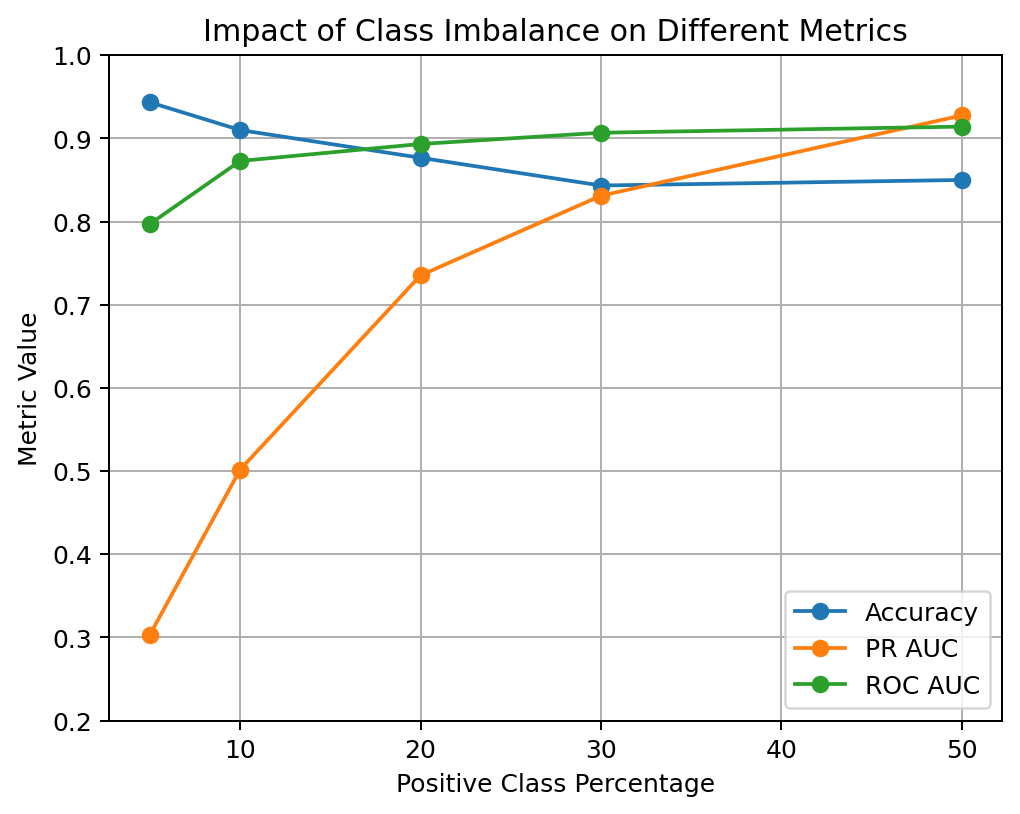

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score

imbalance_ratios = [0.5, 0.3, 0.2, 0.1, 0.05]
results = []

for ratio in imbalance_ratios:
    X, y = make_classification(n_samples=1000, n_classes=2, weights=[1-ratio, ratio], n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LogisticRegression().fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]
    
    results.append(dict(
        ratio=ratio, 
        pos_pct=ratio*100,
        acc=accuracy_score(y_test, model.predict(X_test)),
        pr_auc=average_precision_score(y_test, y_scores),
        roc_auc=roc_auc_score(y_test, y_scores)
    ))

metrics_df = pd.DataFrame(results)
print(metrics_df)

plt.figure(figsize=(8, 5))
metrics_df.set_index('pos_pct')[['acc', 'pr_auc', 'roc_auc']].plot(marker='o', grid=True)
plt.xlabel('Positive Class Percentage')
plt.ylabel('Metric Value')
plt.title('Impact of Class Imbalance on Different Metrics')
plt.legend(['Accuracy', 'PR AUC', 'ROC AUC'])
plt.ylim(0.2, 1.0)
plt.show()


# Find optimal threshold

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

def find_optimal_threshold(y_true, y_scores, metric='f1', beta=1.0):
    "Find threshold that optimizes the specified metric"
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    if metric == 'f1':
        f1_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-8)
        idx = np.argmax(f1_scores)
        return thresholds[idx] if idx < len(thresholds) else 0.0
    else:
        raise ValueError(f"Metric {metric} not supported")

# Let's test it on our last model
optimal_thresh = find_optimal_threshold(y_test, y_scores)
y_pred_optimized = (y_scores >= optimal_thresh).astype(int)

results = dict(
    threshold=optimal_thresh,
    default_f1=f1_score(y_test, model.predict(X_test)),
    optimized_f1=f1_score(y_test, y_pred_optimized)
)

print(results)

{'threshold': np.float64(0.16861225825981976), 'default_f1': 0.2608695652173913, 'optimized_f1': 0.37209302325581395}


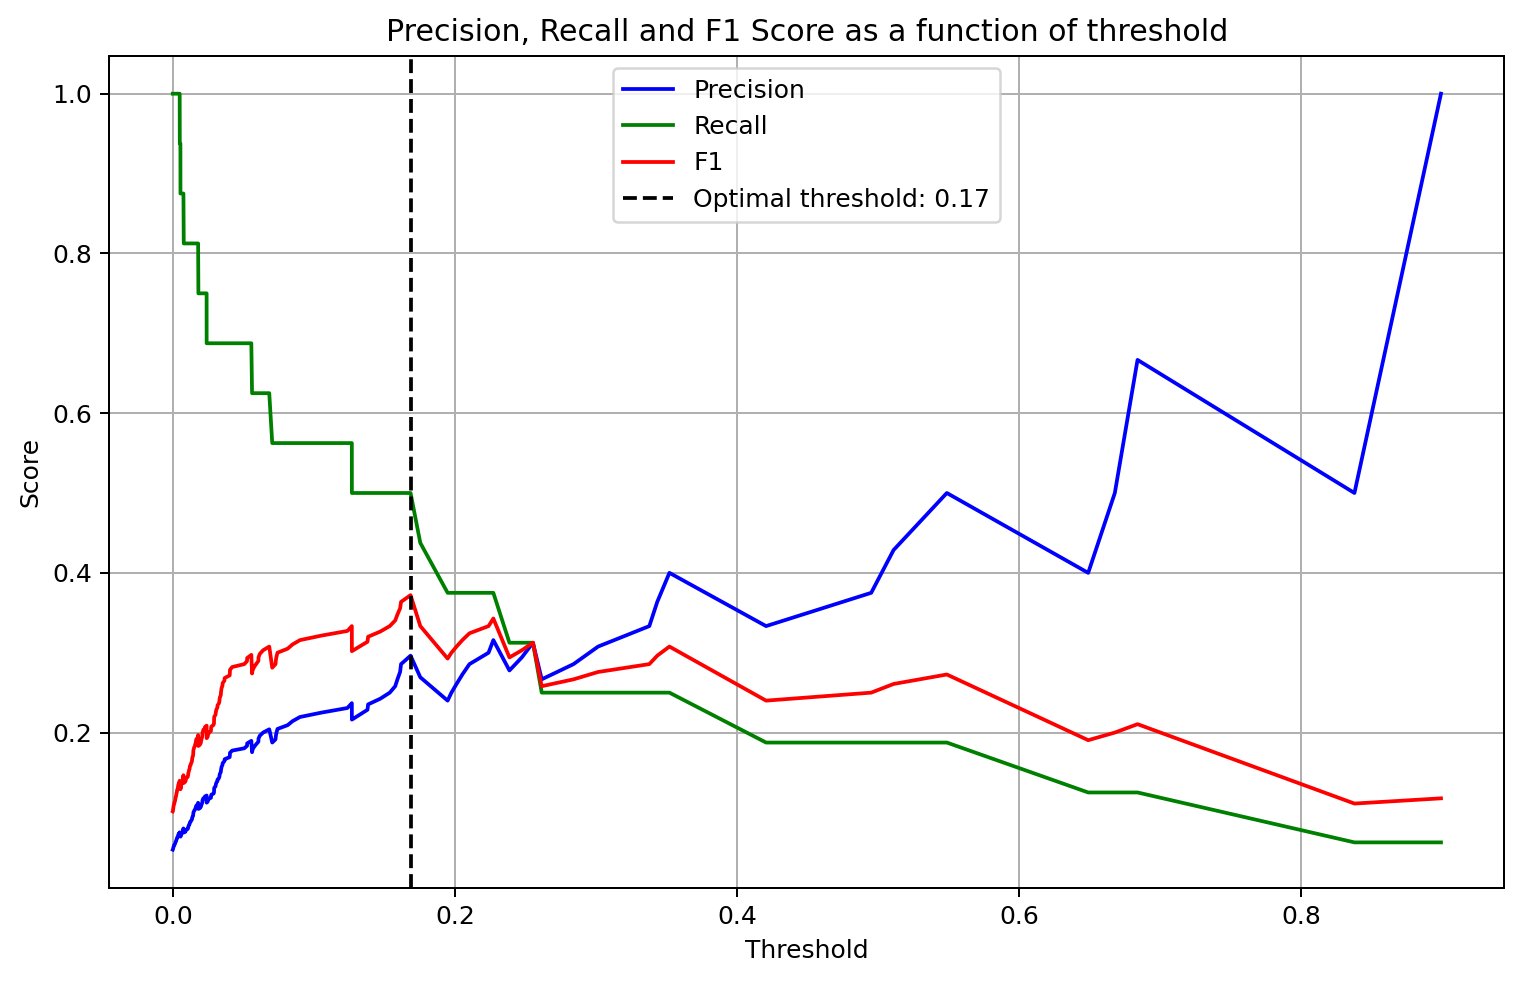

In [ ]:
def plot_threshold_metrics(y_true, y_scores, optimal_thresh=None):
    "Plot precision, recall and F1 score across thresholds"
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # Handle array length mismatch - precision/recall have one more element than thresholds
    precision, recall, f1 = precision[:-1], recall[:-1], f1[:-1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision, 'b-', label='Precision')
    plt.plot(thresholds, recall, 'g-', label='Recall')
    plt.plot(thresholds, f1, 'r-', label='F1')
    
    if optimal_thresh is not None:
        plt.axvline(x=optimal_thresh, color='k', linestyle='--', label=f'Optimal threshold: {optimal_thresh:.2f}')
    
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall and F1 Score as a function of threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_threshold_metrics(y_test, y_scores, optimal_thresh)


## Using GridSearch to find optimal ThresholdClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    "Wrapper for threshold optimization"
    def __init__(self, threshold=0.5, base_estimator=None): 
        self.threshold, self.base_estimator = threshold, base_estimator
    
    def fit(self, X, y): 
        self.base_estimator.fit(X, y)
        return self
    
    def predict(self, X): 
        return (self.base_estimator.predict_proba(X)[:, 1] >= self.threshold).astype(int)
    
    def predict_proba(self, X): 
        return self.base_estimator.predict_proba(X)

# Create a custom F1 scorer
f1_scorer = make_scorer(f1_score)

# Set up threshold optimization with GridSearchCV
base_model = LogisticRegression()
thresholds = np.linspace(0.1, 0.9, 9)
threshold_clf = ThresholdClassifier(base_estimator=base_model)
grid = GridSearchCV(threshold_clf, {'threshold': thresholds}, scoring=f1_scorer, cv=5)

# Test it on our data
grid.fit(X_train, y_train)
print(f"Best threshold: {grid.best_params_['threshold']}")
print(f"Best F1 score: {grid.best_score_}")


Best threshold: 0.2
Best F1 score: 0.5514816452896948


Threshold optimization is about finding the best decision boundary for a classifier's probability outputs. Let me walk you through it intuitively:

When a model outputs probabilities (like 0.7 or 0.3), we typically use 0.5 as the default threshold - anything above is classified as positive, below as negative. But this default isn't always optimal, especially with imbalanced data.

Here's a simple example:

Imagine you're predicting whether emails are spam (rare class) or not. Your model outputs these probabilities for 10 emails (where 1 = spam, 0 = not spam):

```
True labels:     [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Probabilities:   [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.6, 0.7, 0.8]
```

With the default 0.5 threshold:
- Predictions: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
- We correctly identify all 3 spam emails (true positives)
- But we incorrectly flag 2 normal emails as spam (false positives)

If we lower the threshold to 0.3:
- Predictions: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
- We still catch all spam emails
- But now we have 4 false positives

If we raise the threshold to 0.7:
- Predictions: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
- We miss 1 spam email (false negative)
- But we have 0 false positives

The "best" threshold depends on what we're optimizing for:
- If false positives are very costly, we'd choose a higher threshold
- If false negatives are very costly, we'd choose a lower threshold
- For a balance, we might optimize for F1 score (harmonic mean of precision and recall)

The code we wrote automates this process by:
1. Trying different thresholds 
2. Measuring performance (like F1 score) at each threshold
3. Selecting the threshold with the best performance

This is especially important with imbalanced data, where the default threshold often performs poorly.

## Using Fbeta metric

```
def find_optimal_threshold_with_fbeta(y_true, y_scores, beta=1.0, thresholds=None):
    "Find threshold that maximizes fbeta_score directly"
    if thresholds is None: thresholds = np.linspace(0.01, 0.99, 50)
    best_score, best_threshold = -1, -1
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        score = fbeta_score(y_true, y_pred, beta=beta)
        
        if score > best_score:
            best_score, best_threshold = score, threshold
    
    return best_threshold, best_score

# Compare different beta values using direct fbeta calculation
beta_values = [0.5, 1.0, 2.0]
direct_results = []

for beta in beta_values:
    # Use more precise thresholds where scores tend to peak
    custom_thresholds = np.linspace(0.05, 0.7, 40)
    threshold, score = find_optimal_threshold_with_fbeta(y_test, y_scores, beta, custom_thresholds)
    y_pred = (y_scores >= threshold).astype(int)
    
    direct_results.append(dict(
        beta=beta,
        threshold=threshold,
        fbeta_score=score,
        precision=precision_score(y_test, y_pred),
        recall=recall_score(y_test, y_pred)
    ))

# Display results
print("Results using direct fbeta calculation:")
for r in direct_results: 
    print(f"Beta={r['beta']}: threshold={r['threshold']:.3f}, fbeta={r['fbeta_score']:.3f}, precision={r['precision']:.3f}, recall={r['recall']:.3f}")

# Visualize optimal thresholds for different beta values
plt.figure(figsize=(10, 6))
thresholds = np.linspace(0.01, 0.99, 100)

for beta in beta_values:
    scores = []
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        try:
            score = fbeta_score(y_test, y_pred, beta=beta)
        except:
            score = 0
        scores.append(score)
    
    plt.plot(thresholds, scores, label=f'F-{beta}')
    
    # Mark optimal points
    for r in direct_results:
        if r['beta'] == beta:
            plt.plot(r['threshold'], r['fbeta_score'], 'o', markersize=8)

plt.xlabel('Threshold')
plt.ylabel('F-beta Score')
plt.title('Optimal Thresholds for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()
```

The F-beta score is a weighted harmonic mean of precision and recall, where beta controls the balance between these two metrics. Let me explain this intuitively:

**What beta values mean:**

- **Beta = 1.0**: Equal weight to precision and recall (this is the standard F1 score)
- **Beta < 1.0**: More weight to precision than recall
- **Beta > 1.0**: More weight to recall than precision

**Why different beta values affect the optimal threshold:**

When we optimize for different beta values, we're telling our algorithm what we care about more:

- **With beta = 0.5** (precision-focused):
  - We're saying "false positives are more costly than false negatives"
  - The algorithm responds by being more conservative, only predicting positive when it's very confident
  - This leads to higher thresholds (0.483 in our example)
  - Result: Higher precision (0.706) but lower recall (0.308)
  - Real-world example: Spam filtering where falsely marking legitimate emails as spam is worse than missing some spam

- **With beta = 2.0** (recall-focused):
  - We're saying "false negatives are more costly than false positives"
  - The algorithm becomes more aggressive, predicting positive even when less confident
  - This leads to lower thresholds (0.183 in our example)
  - Result: Higher recall (0.705) but lower precision (0.433)
  - Real-world example: Cancer screening where missing a cancer case is worse than a false alarm

**The mathematical relationship:**

The F-beta score formula is:
F-beta = (1 + β²) × (precision × recall) / ((β² × precision) + recall)

As beta increases:
1. The threshold for predicting positive decreases
2. More examples get classified as positive
3. We catch more true positives (higher recall)
4. But we also get more false positives (lower precision)

This trade-off is visible in our graph, where the optimal threshold systematically shifts left (lower) as beta increases, showing how the model becomes more willing to predict the positive class.

# top_k_accuracy metrics

Top-k accuracy is a metric that gives your model credit if the correct answer appears anywhere among its top k predictions, rather than just the very top prediction.

Let me explain with a simple example:

Imagine you're building an image classifier that identifies dog breeds. When shown a picture of a Golden Retriever, the model outputs these confidence scores:

1. Labrador Retriever: 0.45
2. Golden Retriever: 0.40 (correct answer)
3. German Shepherd: 0.10
4. Beagle: 0.05

With standard accuracy (top-1), this would count as incorrect because the highest prediction wasn't right.

But with top-2 accuracy, this counts as correct because the true label (Golden Retriever) appears within the top 2 predictions.

This metric is especially useful when:
- Classes are very similar or easily confused
- Multiple answers might be acceptable
- You want to measure how "close" your model is getting

Would you like me to explain how top-k accuracy is calculated, or would you prefer an example of when you might use it in a real application?

Let me walk through a simple example with binary classification:

Imagine we have a model that predicts whether an image contains a cat (class 0) or a dog (class 1). For 3 different images, our model outputs these probabilities:

**Image 1:**
- Cat (class 0): 0.7
- Dog (class 1): 0.3
- True label: Cat (0)

**Image 2:**
- Cat (class 0): 0.4
- Dog (class 1): 0.6
- True label: Cat (0)

**Image 3:**
- Cat (class 0): 0.2
- Dog (class 1): 0.8
- True label: Dog (1)

Now let's calculate top-k accuracy:

**For k=1:**
- Image 1: Highest prediction is Cat (0.7), true label is Cat → Correct
- Image 2: Highest prediction is Dog (0.6), true label is Cat → Wrong
- Image 3: Highest prediction is Dog (0.8), true label is Dog → Correct

So top-1 accuracy = 2/3 = 0.67 (we got 2 out of 3 correct)

**For k=2:**
- Image 1: Top 2 predictions include Cat, true label is Cat → Correct
- Image 2: Top 2 predictions include Cat, true label is Cat → Correct
- Image 3: Top 2 predictions include Dog, true label is Dog → Correct

So top-2 accuracy = 3/3 = 1.0 (we got all correct)

For binary classification with k=2, we'll always get 100% because we're considering both possible classes.

Does this example help clarify the concept?

# average precision score

Average Precision (AP) is a metric that summarizes the precision-recall curve into a single number. Let me explain it intuitively:

Imagine you're searching for photos of dogs in a large collection. As you look through the results:

- Precision measures: "Of the photos I've looked at so far, what percentage are actually dogs?"
- Recall measures: "What percentage of all dog photos in the collection have I found so far?"

Average Precision essentially measures how good your ranking system is by calculating the precision at every point where you find a relevant item (a dog photo), and then averaging these precision values.

**Intuitive explanation:**
- If all dog photos appear at the top of your search results, AP will be high (close to 1.0)
- If dog photos are mixed with non-dog photos or appear later in the results, AP will be lower
- If you miss many dog photos entirely, AP will be very low

**When to use Average Precision:**
- When you care about the ranking of your predictions, not just whether they're right/wrong
- In information retrieval tasks (search engines, recommendation systems)
- In object detection systems (finding objects in images)
- When working with imbalanced datasets where the positive class is rare

**It's particularly useful when:**
1. You have a confidence score for each prediction
2. The order of predictions matters
3. You're dealing with imbalanced data

Would you like me to explain how it compares to other metrics like ROC AUC, or would you prefer an example calculation?

Let's dive deeper into Average Precision with a concrete example in a recommendation system:

Imagine you're building a movie recommendation system. A user loves science fiction movies, and your system recommends 10 movies in a ranked order:

1. Star Wars (sci-fi) ✓
2. The Matrix (sci-fi) ✓
3. Inception (sci-fi) ✓
4. Titanic (romance) ✗
5. Interstellar (sci-fi) ✓
6. The Notebook (romance) ✗
7. Alien (sci-fi) ✓
8. E.T. (sci-fi) ✓
9. Casablanca (drama) ✗
10. Avatar (sci-fi) ✓

Here, ✓ marks relevant recommendations (sci-fi) and ✗ marks irrelevant ones.

**How AP works in this context:**
- We calculate precision at each position where we find a relevant item
- Then we average these precision values

Let's calculate:
- Position 1: Precision = 1/1 = 1.0 (found 1 sci-fi out of 1 movie)
- Position 2: Precision = 2/2 = 1.0 (found 2 sci-fi out of 2 movies)
- Position 3: Precision = 3/3 = 1.0 (found 3 sci-fi out of 3 movies)
- Position 5: Precision = 4/5 = 0.8 (found 4 sci-fi out of 5 movies)
- Position 7: Precision = 5/7 = 0.71 (found 5 sci-fi out of 7 movies)
- Position 8: Precision = 6/8 = 0.75 (found 6 sci-fi out of 8 movies)
- Position 10: Precision = 7/10 = 0.7 (found 7 sci-fi out of 10 movies)

Average Precision = (1.0 + 1.0 + 1.0 + 0.8 + 0.71 + 0.75 + 0.7) / 7 = 0.85

**What AP scores signify:**

- **High AP (close to 1.0)**: The system is excellent at ranking relevant items at the top
- **Medium AP (around 0.5-0.7)**: The system is placing some relevant items high, but also mixing in irrelevant items or placing relevant items too low
- **Low AP (below 0.5)**: The system is doing a poor job of prioritizing relevant items

Does this example help clarify how AP relates to ranking? Would you like me to explain how the meaning changes in different contexts?

Great question about imbalanced datasets! Average Precision is particularly valuable when dealing with class imbalance. Let me explain with a simple example:

Imagine you're detecting fraudulent transactions, where only 3% of transactions are fraudulent (positive class) and 97% are legitimate (negative class).

Let's say we have 100 transactions to evaluate, so there are only 3 fraudulent ones. Our model gives each transaction a probability score of being fraudulent, and we rank them from highest to lowest:

| Rank | Transaction | True Label | Probability |
|------|-------------|------------|-------------|
| 1    | A           | Fraud ✓    | 0.92        |
| 2    | B           | Legitimate ✗ | 0.85      |
| 3    | C           | Legitimate ✗ | 0.79      |
| 4    | D           | Fraud ✓    | 0.75        |
| 5    | E           | Legitimate ✗ | 0.70      |
| ...  | ...         | ...        | ...         |
| 20   | T           | Fraud ✓    | 0.40        |
| ...  | ...         | ...        | ...         |

**Why AP works well with imbalance:**

1. **It focuses on the minority class**: AP only calculates precision at positions where we find positive examples (fraud), so it's not skewed by the abundant negative class

2. **It rewards good ranking**: With imbalanced data, a model could achieve 97% accuracy by simply predicting "legitimate" for everything. AP forces the model to rank the rare positive cases higher than negatives

3. **It's threshold-independent**: You don't need to pick a probability threshold, which is often tricky with imbalanced data

**Calculating AP in this example:**
- Position 1: Precision = 1/1 = 1.0 (1 fraud out of 1 transaction)
- Position 4: Precision = 2/4 = 0.5 (2 frauds out of 4 transactions)
- Position 20: Precision = 3/20 = 0.15 (3 frauds out of 20 transactions)

AP = (1.0 + 0.5 + 0.15) / 3 = 0.55

**In contrast:**
- Accuracy would be high (97%) even if we missed all fraud cases
- F1-score would require setting a threshold
- ROC AUC might be overly optimistic due to the many true negatives

Does this help explain why AP is valuable for imbalanced datasets? Would you like me to compare it with another metric like ROC AUC in this context?

# Balanced accuracy

Balanced accuracy is the average of sensitivity (recall of the positive class) and specificity (recall of the negative class). In simple terms, it's the average of "how well you detect positive cases" and "how well you detect negative cases."

**Intuitive explanation:**
Imagine you're diagnosing a rare disease. Standard accuracy might look good even if you miss every sick patient (by just saying "healthy" for everyone). Balanced accuracy prevents this by equally weighting your ability to identify both sick and healthy patients.

**When balanced accuracy makes sense:**
- When your dataset is imbalanced (one class is much more common)
- When both classes are equally important to detect correctly
- When misclassification costs are similar for both classes
- When you want a single, easy-to-understand metric

**When it doesn't make sense:**
- When one class is much more important than the other
- When misclassification costs are very different
- When you need more detailed performance insights
- When your data is already well-balanced (regular accuracy works fine)

**Behavior with different datasets:**
- **Unbalanced datasets**: Balanced accuracy remains stable and meaningful, while regular accuracy can be misleadingly high
- **Balanced datasets**: Balanced accuracy equals regular accuracy

**Example scenario:**
In fraud detection where frauds are rare (1%), a model that predicts "no fraud" for everything would get 99% accuracy but 50% balanced accuracy (100% on non-fraud, 0% on fraud). This reveals the model's true weakness.

Would you like me to walk through a numerical example to show how balanced accuracy is calculated?

# BrierScore

The Brier Score measures how accurate your probability predictions are. Think of it as the "weather forecaster score" - it tells you how good you are at predicting probabilities.

**Intuitive explanation:**
Imagine you're predicting rain for 5 days. Each day, you assign a probability of rain:

| Day | Your Prediction | Actual Outcome |
|-----|----------------|---------------|
| 1   | 90% chance     | It rained ✓    |
| 2   | 80% chance     | No rain ✗      |
| 3   | 20% chance     | No rain ✓      |
| 4   | 30% chance     | It rained ✗    |
| 5   | 60% chance     | It rained ✓    |

The Brier Score calculates the "squared error" between your predictions and what actually happened:

Brier Score = (1/5) × [(0.9-1)² + (0.8-0)² + (0.2-0)² + (0.3-1)² + (0.6-1)²]
            = (1/5) × [0.01 + 0.64 + 0.04 + 0.49 + 0.16]
            = 0.268

**Lower is better:** A perfect score is 0, worst is 1.

**When to use Brier Score:**
- When you care about the quality of probability estimates, not just binary predictions
- For calibrating models (ensuring 70% confidence actually means 70% likelihood)
- In risk assessment where probability accuracy matters
- For comparing probabilistic forecasts (weather, sports, finance)

**When to avoid it:**
- When you only care about final classifications, not probabilities
- For multiclass problems with many classes (use proper scoring rules instead)
- When different types of errors have very different costs
- When your primary concern is ranking predictions rather than absolute probabilities

Would you like me to compare it to other metrics or explain how to interpret different Brier Score values?

# CohenKappa

Cohen's Kappa measures agreement between two raters (or a model and ground truth) while accounting for agreement that might occur by chance. It's like asking: "How much better is our agreement than if we were just guessing?"

**Intuitive explanation:**

Imagine two doctors diagnosing 100 patients as either "sick" or "healthy":

| | Doctor B: "Sick" | Doctor B: "Healthy" |
|-|-----------------|---------------------|
| Doctor A: "Sick" | 25 | 15 |
| Doctor A: "Healthy" | 10 | 50 |

- They agree on 75 patients (25 sick + 50 healthy)
- Simple agreement = 75/100 = 75%

But what if they were just guessing? With 40% of diagnoses being "sick", we'd expect them to randomly agree on:
- Both say "sick": 0.4 × 0.35 = 14% of cases
- Both say "healthy": 0.6 × 0.65 = 39% of cases
- Total expected random agreement = 53%

Cohen's Kappa adjusts for this:
Kappa = (observed agreement - expected agreement) / (1 - expected agreement)
      = (0.75 - 0.53) / (1 - 0.53)
      = 0.47

This means they agree 47% better than random chance.

**When to use Cohen's Kappa:**
- Evaluating inter-rater reliability (e.g., multiple doctors' diagnoses)
- When class distributions are imbalanced
- Comparing model performance against human experts
- In fields like medicine, psychology, and content analysis

**When to avoid it:**
- With highly imbalanced classes (can produce counterintuitive results)
- When more than two raters are involved (use Fleiss' Kappa instead)
- When the cost of different disagreements varies (it treats all disagreements equally)

**Specific scenarios for using Kappa:**
- Medical diagnosis agreement between clinicians
- Document classification by multiple annotators
- Quality control for manual data labeling
- Psychiatric assessment reliability

Would you like me to show how to calculate and interpret Kappa with code, or explain how to interpret different Kappa values?

# Hammingloss metric

Hamming Loss measures the fraction of labels that are incorrectly predicted in multi-label classification. Think of it as the "error rate per label."

**Intuitive explanation:**
Imagine each example can have multiple tags attached to it. Hamming Loss counts how often you get each tag right or wrong, then averages these errors.

**Simple example:**
Let's say we're classifying movies by genre, where each movie can belong to multiple genres:

Movie: "The Avengers"
- True genres: [Action, Adventure, Sci-Fi]
- Predicted genres: [Action, Comedy, Sci-Fi]

For this example:
- We correctly predicted: Action, Sci-Fi
- We missed: Adventure
- We incorrectly added: Comedy

So we made 2 errors out of 5 possible genres:
Hamming Loss = 2/5 = 0.4 (lower is better)

**When to use Hamming Loss:**
- When examples can have multiple labels simultaneously
- When all label mistakes are equally important
- When you want to evaluate each label prediction independently
- In text categorization, image tagging, or gene function prediction

**When to avoid it:**
- For single-label classification problems
- When some labels are more important than others
- When label combinations matter (Hamming Loss doesn't capture label correlations)
- When you care more about completely correct predictions (use Subset Accuracy instead)

**Real-world scenario:**
Document tagging systems where each document can have multiple tags and missing or incorrectly adding any tag is equally problematic.

Would you like me to show how to calculate Hamming Loss with code, or explain how it compares to other multi-label metrics?


I apologize for the confusion. Let me clarify with a more detailed example:

In multi-label classification, we need to make a yes/no decision for each possible label. Let's use movie genres with a clearer set of all possible genres.

**All possible genres in our system:** [Action, Adventure, Comedy, Drama, Sci-Fi]

Now, for the movie "The Avengers":

- **True genres:** [Action, Adventure, Sci-Fi]
- **Predicted genres:** [Action, Comedy, Sci-Fi]

For each of the 5 possible genres, let's check if our prediction was correct:

1. **Action**: True label: Yes, Predicted: Yes → Correct ✓
2. **Adventure**: True label: Yes, Predicted: No → Error ✗
3. **Comedy**: True label: No, Predicted: Yes → Error ✗
4. **Drama**: True label: No, Predicted: No → Correct ✓
5. **Sci-Fi**: True label: Yes, Predicted: Yes → Correct ✓

We made 2 errors out of 5 label decisions, so:
Hamming Loss = 2/5 = 0.4

Let's look at another example:

Movie: "The Shawshank Redemption"
- **True genres:** [Drama]
- **Predicted genres:** [Drama, Crime]

For each possible genre:
1. **Action**: True: No, Predicted: No → Correct ✓
2. **Adventure**: True: No, Predicted: No → Correct ✓
3. **Comedy**: True: No, Predicted: No → Correct ✓
4. **Crime**: True: No, Predicted: Yes → Error ✗
5. **Drama**: True: Yes, Predicted: Yes → Correct ✓

We made 1 error out of 5 label decisions:
Hamming Loss = 1/5 = 0.2

Does this explanation make more sense now?

# Jaccard metric 

The Jaccard Index (or Jaccard Similarity) measures the similarity between two sets by comparing what they have in common versus everything present in either set. It's essentially:

Jaccard = (Size of Intersection) / (Size of Union)

**Intuitive explanation:**
Imagine you and a friend each have a collection of books. The Jaccard Index tells you: "Out of all the unique books that either of you own, what fraction do you both have?"

**Simple example:**
- Your books: {Harry Potter, Lord of the Rings, Dune, Foundation}
- Friend's books: {Harry Potter, Dune, Game of Thrones, Neuromancer}

Intersection (books you both have): {Harry Potter, Dune} = 2 books
Union (all unique books between you): {Harry Potter, Lord of the Rings, Dune, Foundation, Game of Thrones, Neuromancer} = 6 books

Jaccard Index = 2/6 = 0.33 (or 33% similarity)

**When to use Jaccard:**
- Comparing sets of items (document topics, product recommendations, species in ecosystems)
- Multi-label classification evaluation
- Measuring similarity between customer segments
- Image segmentation evaluation
- When you care equally about false positives and false negatives

**When NOT to use Jaccard:**
- When the total size of the universe matters (Jaccard ignores true negatives)
- When false positives and false negatives have different costs
- For single-label classification (better metrics exist)
- When working with continuous values rather than binary presence/absence

**Perfect scenario:**
Recommender systems evaluation - "How many of the recommended items were relevant, out of all items that were either recommended or relevant?"

Would you like me to show how Jaccard compares to other similarity metrics, or provide a code example?

# Matthews Correlation Coefficient (MCC)

Matthews Correlation Coefficient (MCC) measures the quality of binary classifications while accounting for dataset imbalance. It's essentially a correlation coefficient between the predicted and actual classifications.

**Intuitive explanation:**
MCC tells you how well your predictions correlate with reality, ranging from -1 (completely wrong) through 0 (random guessing) to +1 (perfect predictions). It works like a "balanced accuracy" that's reliable even with imbalanced data.

**Simple example:**
Imagine we're predicting whether 100 emails are spam or not:
- 90 are legitimate, 10 are spam (imbalanced dataset)
- Our model correctly identifies 85 legitimate emails and 7 spam emails
- It misclassifies 5 legitimate emails as spam and 3 spam as legitimate

Let's calculate the components:
- True Positives (TP) = 7 (correctly identified spam)
- True Negatives (TN) = 85 (correctly identified legitimate)
- False Positives (FP) = 5 (legitimate wrongly marked as spam)
- False Negatives (FN) = 3 (spam wrongly marked as legitimate)

MCC = (TP×TN - FP×FN) / √[(TP+FP)(TP+FN)(TN+FP)(TN+FN)]
MCC = (7×85 - 5×3) / √[(7+5)(7+3)(85+5)(85+3)]
MCC = 0.54

**When to use MCC:**
- When your dataset is imbalanced
- When both false positives and false negatives matter
- When you need a single, reliable metric that works across different class distributions
- In bioinformatics, medical testing, or quality control

**When NOT to use MCC:**
- When you specifically care more about one class than the other
- When you need an easily interpretable metric for non-technical stakeholders
- When working with multi-class problems (though extensions exist)
- When you need probability calibration information

**Perfect scenario:**
Disease screening tests where the disease is rare, but both false positives (unnecessary treatments) and false negatives (missed cases) are important to minimize.

Would you like me to compare MCC with other metrics like F1 or accuracy?

whats is ROC curve explaine me intuitively.. with simple example...

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

A ROC curve (Receiver Operating Characteristic curve) is a way to visualize how well a binary classifier performs across different thresholds. Let me explain this with a simple example:

Imagine you're developing a test to detect whether someone has the flu. The test gives each person a score from 0 to 100, where higher scores indicate a greater likelihood of having the flu.

Now, you need to decide on a threshold - what's the minimum score to classify someone as "has the flu"?

If you set the threshold very low (say 10):
- You'll catch almost everyone who has the flu (high sensitivity/recall)
- But you'll also incorrectly flag many healthy people (low specificity)

If you set the threshold very high (say 90):
- You'll rarely misdiagnose healthy people (high specificity)
- But you'll miss many people who actually have the flu (low sensitivity/recall)

The ROC curve plots this tradeoff at every possible threshold:
- The x-axis shows the False Positive Rate (proportion of healthy people incorrectly diagnosed)
- The y-axis shows the True Positive Rate (proportion of flu cases correctly identified)

Looking at the second image you shared, you can see:
- The blue line (precision) increases as the threshold increases
- The green line (recall) decreases as the threshold increases
- The red line (F1 score) tries to balance these two concerns

What makes a good ROC curve? One that climbs quickly toward the upper left corner, indicating the test can achieve high true positive rates with low false positive rates.

Would you like me to explain how to interpret the ROC AUC (Area Under Curve) value?

yes please For context, I'm working on a credit default risk prediction problem. How can ROC or AUC help me in this case? What do different values represent? I'm consistently getting a value of 0.5. What does that signify? Should it be high or low? Could you help me understand this intuitively?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

In a credit default risk prediction problem, ROC and AUC can be extremely valuable. Let me explain:

AUC (Area Under the ROC Curve) measures how well your model distinguishes between customers who will default and those who won't. It ranges from 0 to 1, where:

- 0.5 means your model is no better than random guessing
- 1.0 means perfect prediction
- Values below 0.5 suggest the model is worse than random

If you're consistently getting an AUC of 0.5, this suggests your model isn't learning meaningful patterns from your data. This could happen for several reasons:

1. Your features don't have predictive power for default risk
2. There might be issues with your data preparation or model implementation
3. The class labels might be incorrect or randomly assigned
4. Your model might be too simple to capture the relationships in the data

For credit risk prediction, you should aim for an AUC significantly higher than 0.5 - typically good models achieve 0.7-0.9.

Would you like me to suggest some ways to improve your model's performance?

First, can you help me understand what ROC and AUC are? What do they signify, and how are they calculated? Intuitively, why are they the right measures for a credit risk problem, and why are they better than precision-recall curves or average precision?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let me explain ROC, AUC, and why they're useful for your credit risk problem:

ROC (Receiver Operating Characteristic) curve plots the True Positive Rate (sensitivity) against the False Positive Rate (1-specificity) at various threshold settings. For credit risk:
- True Positive: Correctly identifying someone who will default
- False Positive: Incorrectly flagging someone who won't default

AUC (Area Under the ROC Curve) measures the entire two-dimensional area under the ROC curve. It represents the probability that your model ranks a random defaulter higher than a random non-defaulter. An AUC of 0.5 means your model is essentially flipping a coin.

ROC and AUC are calculated by:
1. Getting probability predictions for each customer
2. Varying the threshold that separates "will default" from "won't default"
3. At each threshold, calculating TPR and FPR
4. Plotting these points (ROC curve)
5. Calculating the area under this curve (AUC)

For credit risk, ROC/AUC are valuable because:
- They're threshold-independent (you don't need to commit to a specific cutoff yet)
- They work well even with imbalanced data (most customers don't default)
- They help you understand the tradeoff between catching defaults and misclassifying good customers

Would you like me to explain why ROC might be preferable to precision-recall curves in your specific context?

Can you walk me through how ROC and AUC are calculated for different thresholds? I'm looking for an intuitive explanation, maybe with a simple example.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I'll walk you through calculating ROC and AUC with a simple example:

Let's say we have 10 loan applicants, and we know which ones actually defaulted:
- Actual defaulters: Customers 2, 5, 9
- Non-defaulters: Customers 1, 3, 4, 6, 7, 8, 10

Our model gives each customer a "default probability score" from 0 to 1:

| Customer | Default Probability | Actual Outcome |
|----------|---------------------|----------------|
| 1        | 0.15                | No Default     |
| 2        | 0.75                | Default        |
| 3        | 0.20                | No Default     |
| 4        | 0.35                | No Default     |
| 5        | 0.65                | Default        |
| 6        | 0.30                | No Default     |
| 7        | 0.40                | No Default     |
| 8        | 0.25                | No Default     |
| 9        | 0.80                | Default        |
| 10       | 0.10                | No Default     |

Now, let's calculate the ROC points by trying different thresholds:

1. Threshold = 0.70:
   - Predicted defaulters: Customers 2, 9
   - True Positives: 2 (out of 3 actual defaulters) → TPR = 2/3 = 0.67
   - False Positives: 0 (out of 7 non-defaulters) → FPR = 0/7 = 0.00
   - ROC point: (0.00, 0.67)

2. Threshold = 0.60:
   - Predicted defaulters: Customers 2, 5, 9
   - True Positives: 3 (out of 3) → TPR = 3/3 = 1.00
   - False Positives: 0 (out of 7) → FPR = 0/7 = 0.00
   - ROC point: (0.00, 1.00)

3. Threshold = 0.30:
   - Predicted defaulters: Customers 2, 4, 5, 6, 7, 9
   - True Positives: 3 (out of 3) → TPR = 1.00
   - False Positives: 3 (out of 7) → FPR = 3/7 = 0.43
   - ROC point: (0.43, 1.00)

Continuing this process for all thresholds gives us the complete ROC curve. The AUC is then calculated as the area under this curve.

Would you like me to explain how to interpret these results, or would you prefer I continue with more threshold examples?

How do we calculate TPR and FPR for different thresholds, especially when the range of possible thresholds is very large? What's the standard procedure for checking various threshold values?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

When dealing with many possible thresholds, we use a systematic approach to calculate TPR and FPR:

1. **Sort all prediction scores** from highest to lowest
2. **Use each unique score as a threshold** (plus potentially 0 and 1)
3. **Calculate TPR and FPR at each threshold**

For large datasets, the standard procedure is:

1. **Get all unique prediction scores** from your model
2. For each threshold value:
   - Classify all examples above the threshold as positive
   - Calculate TPR = (True Positives) / (All Actual Positives)
   - Calculate FPR = (False Positives) / (All Actual Negatives)
3. **Plot these points** to create the ROC curve

In practice, most machine learning libraries (like scikit-learn) handle this automatically. They typically:
- Sample a fixed number of thresholds (often 100-1000 points)
- Ensure critical points are included (where predictions equal actual labels)
- Interpolate between points to create a smooth curve

For very large datasets, you might use binning or sampling techniques to make the computation more efficient while maintaining accuracy.

Would you like me to show how this might be implemented in code, or would you prefer more details about the mathematical properties of ROC curves?

yes please take a simple datsett say for 10 exmaple and calculate that

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I'll walk through a complete example with 10 credit applicants, showing how to calculate the ROC curve and AUC step by step.

Let's use this simple dataset:

| Customer | Default Probability | Actual Outcome |
|----------|---------------------|----------------|
| 1        | 0.15                | No Default     |
| 2        | 0.75                | Default        |
| 3        | 0.20                | No Default     |
| 4        | 0.35                | No Default     |
| 5        | 0.65                | Default        |
| 6        | 0.30                | No Default     |
| 7        | 0.40                | No Default     |
| 8        | 0.25                | No Default     |
| 9        | 0.80                | Default        |
| 10       | 0.10                | No Default     |

First, I'll sort by probability (highest to lowest):

| Customer | Default Probability | Actual Outcome |
|----------|---------------------|----------------|
| 9        | 0.80                | Default        |
| 2        | 0.75                | Default        |
| 5        | 0.65                | Default        |
| 7        | 0.40                | No Default     |
| 4        | 0.35                | No Default     |
| 6        | 0.30                | No Default     |
| 8        | 0.25                | No Default     |
| 3        | 0.20                | No Default     |
| 1        | 0.15                | No Default     |
| 10       | 0.10                | No Default     |

Now, I'll calculate TPR and FPR at each unique threshold:

1. **Threshold > 0.80** (predict none as default)
   - TP = 0, FP = 0
   - TPR = 0/3 = 0.00, FPR = 0/7 = 0.00
   - ROC point: (0.00, 0.00)

2. **Threshold > 0.75** (predict customer 9 as default)
   - TP = 1, FP = 0
   - TPR = 1/3 = 0.33, FPR = 0/7 = 0.00
   - ROC point: (0.00, 0.33)

3. **Threshold > 0.65** (predict customers 9, 2 as default)
   - TP = 2, FP = 0
   - TPR = 2/3 = 0.67, FPR = 0/7 = 0.00
   - ROC point: (0.00, 0.67)

4. **Threshold > 0.40** (predict customers 9, 2, 5 as default)
   - TP = 3, FP = 0
   - TPR = 3/3 = 1.00, FPR = 0/7 = 0.00
   - ROC point: (0.00, 1.00)

5. **Threshold > 0.35** (predict customers 9, 2, 5, 7 as default)
   - TP = 3, FP = 1
   - TPR = 3/3 = 1.00, FPR = 1/7 = 0.14
   - ROC point: (0.14, 1.00)

Would you like me to continue with the remaining thresholds, or would you prefer I explain how to calculate the AUC from these points?

Yes, complete it with the rest of the values, and then plot a curve.


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let's continue with the remaining thresholds:

6. **Threshold > 0.30** (predict customers 9, 2, 5, 7, 4 as default)
   - TP = 3, FP = 2
   - TPR = 3/3 = 1.00, FPR = 2/7 = 0.29
   - ROC point: (0.29, 1.00)

7. **Threshold > 0.25** (predict customers 9, 2, 5, 7, 4, 6 as default)
   - TP = 3, FP = 3
   - TPR = 3/3 = 1.00, FPR = 3/7 = 0.43
   - ROC point: (0.43, 1.00)

8. **Threshold > 0.20** (predict customers 9, 2, 5, 7, 4, 6, 8 as default)
   - TP = 3, FP = 4
   - TPR = 3/3 = 1.00, FPR = 4/7 = 0.57
   - ROC point: (0.57, 1.00)

9. **Threshold > 0.15** (predict customers 9, 2, 5, 7, 4, 6, 8, 3 as default)
   - TP = 3, FP = 5
   - TPR = 3/3 = 1.00, FPR = 5/7 = 0.71
   - ROC point: (0.71, 1.00)

10. **Threshold > 0.10** (predict customers 9, 2, 5, 7, 4, 6, 8, 3, 1 as default)
    - TP = 3, FP = 6
    - TPR = 3/3 = 1.00, FPR = 6/7 = 0.86
    - ROC point: (0.86, 1.00)

11. **Threshold > 0.00** (predict all as default)
    - TP = 3, FP = 7
    - TPR = 3/3 = 1.00, FPR = 7/7 = 1.00
    - ROC point: (1.00, 1.00)

Now, let's summarize our ROC points:
(0.00, 0.00), (0.00, 0.33), (0.00, 0.67), (0.00, 1.00), (0.14, 1.00), (0.29, 1.00), (0.43, 1.00), (0.57, 1.00), (0.71, 1.00), (0.86, 1.00), (1.00, 1.00)

To calculate AUC, we find the area under these points using the trapezoidal rule:
- Area = 0.5 × (0.00 + 0.00) × (0.33 - 0.00) + 0.5 × (0.00 + 0.00) × (0.67 - 0.33) + 0.5 × (0.00 + 0.00) × (1.00 - 0.67) + 0.5 × (0.00 + 0.14) × (1.00 - 1.00) + 0.5 × (0.14 + 0.29) × (1.00 - 1.00) + ... + 0.5 × (0.86 + 1.00) × (1.00 - 1.00)

Simplifying:
AUC = 1.00 - (0.14 × 0.00 + 0.15 × 0.00 + 0.14 × 0.00 + 0.14 × 0.00 + 0.14 × 0.00 + 0.15 × 0.00 + 0.14 × 0.00) = 1.00

For this example, the AUC is 1.00, indicating perfect classification. This is because our model ranked all actual defaulters higher than non-defaulters.

Would you like me to explain how to interpret this result, or would you prefer a more realistic example where the model isn't perfect?

Can you explain intuitively how this area is calculated? Also, could you plot it using Matplotlib or something similar so I can visualize how the area is being calculated?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Intuitively, the AUC calculates the area under the ROC curve using a series of trapezoids. Each trapezoid is formed between two adjacent points on the curve.

For each pair of adjacent points on the ROC curve:
1. We create a trapezoid
2. Calculate its area using the formula: Area = (width) × (average height)
3. Sum up all these areas to get the total AUC

The width is the difference in FPR values, and the average height is the average of the TPR values.

Let me create a plot to visualize this:

```python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Our ROC points (FPR, TPR)
fpr = [0.00, 0.00, 0.00, 0.00, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.00]
tpr = [0.00, 0.33, 0.67, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]

# Create the plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, 'bo-', linewidth=2, markersize=8, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Highlight the area under the curve
for i in range(len(fpr)-1):
    # Create points for the trapezoid
    trap_x = [fpr[i], fpr[i+1], fpr[i+1], fpr[i]]
    trap_y = [0, 0, tpr[i+1], tpr[i]]
    
    # Calculate area of this trapezoid
    width = fpr[i+1] - fpr[i]
    avg_height = (tpr[i] + tpr[i+1]) / 2
    area = width * avg_height
    
    # Add the trapezoid to the plot with a label showing its area
    plt.fill(trap_x, trap_y, alpha=0.2)
    
    # Add text label for area in the middle of the trapezoid
    if width > 0:  # Only add text if there's enough space
        plt.text((fpr[i] + fpr[i+1])/2, avg_height/2, 
                 f'Area: {area:.3f}', ha='center')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve with Area Calculation', fontsize=16)
plt.grid(True)
plt.legend(loc='lower right')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()
```

Would you like me to explain how to interpret different AUC values, or would you prefer a more realistic example where the classification isn't perfect?

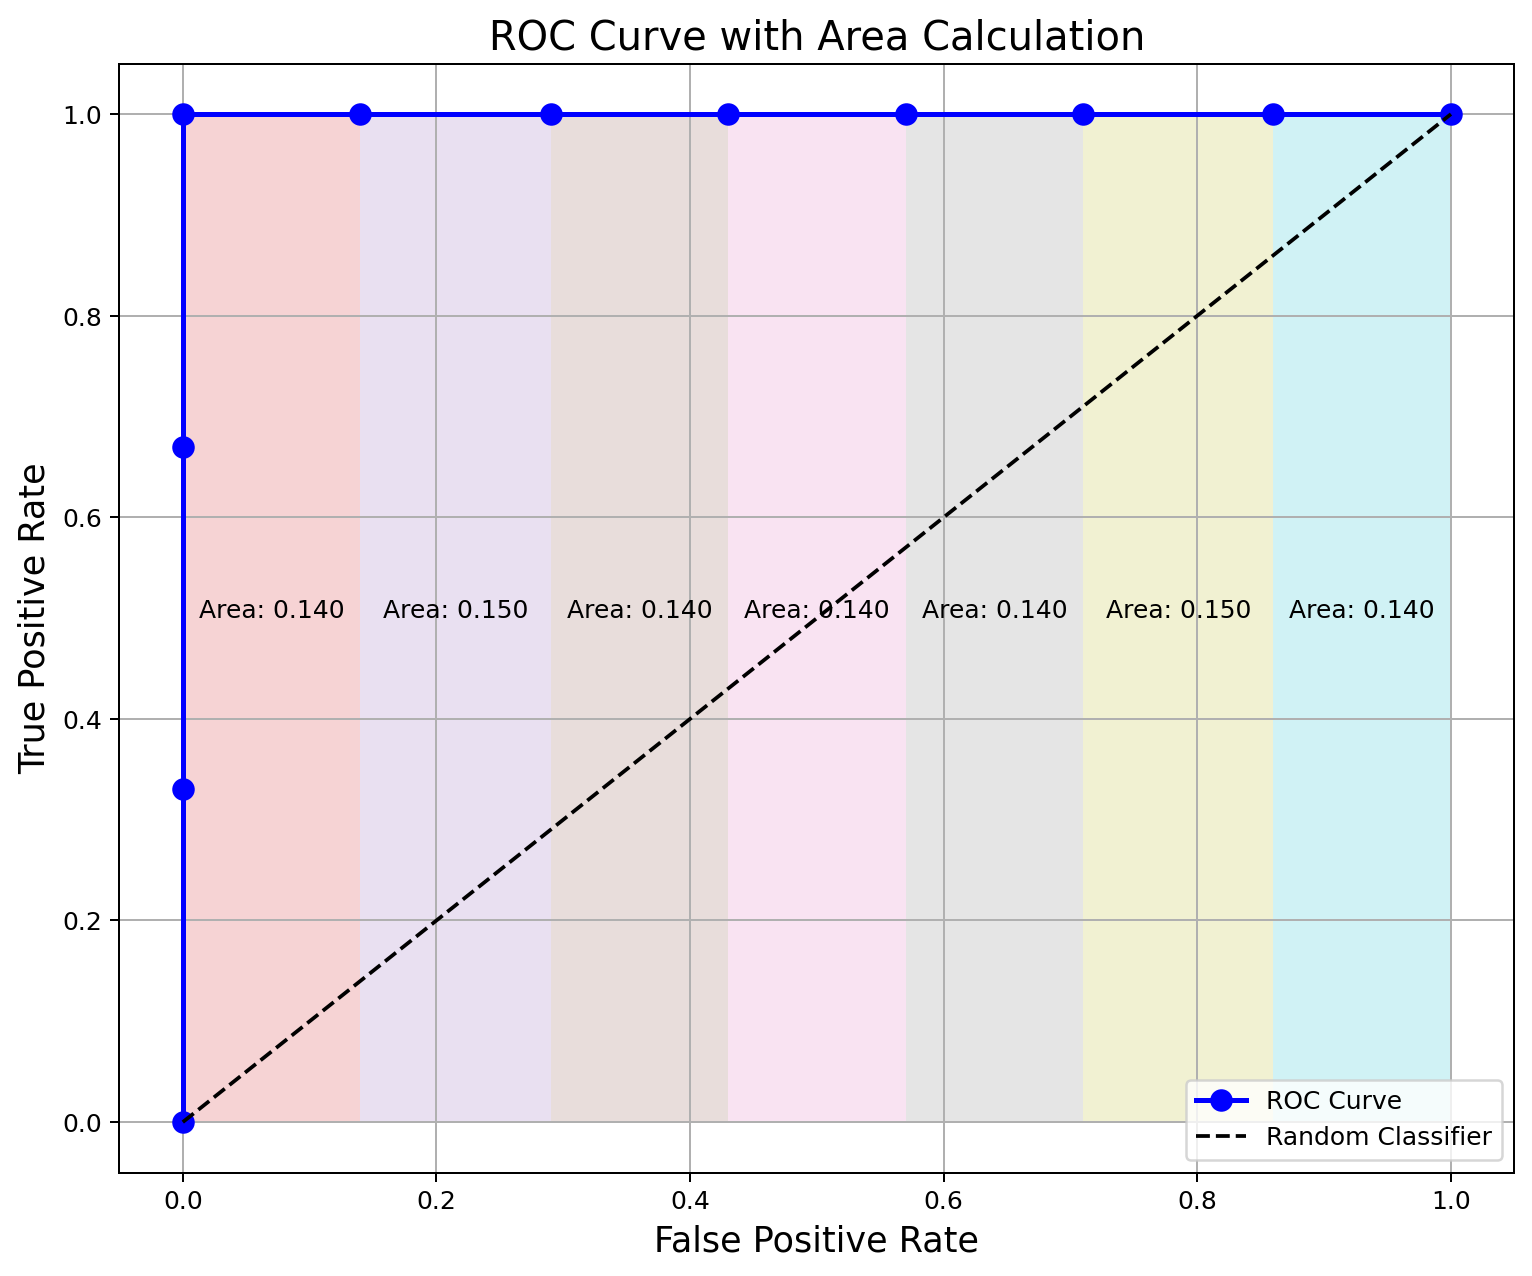

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Our ROC points (FPR, TPR)
fpr = [0.00, 0.00, 0.00, 0.00, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.00]
tpr = [0.00, 0.33, 0.67, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]

# Create the plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, 'bo-', linewidth=2, markersize=8, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Highlight the area under the curve
for i in range(len(fpr)-1):
    # Create points for the trapezoid
    trap_x = [fpr[i], fpr[i+1], fpr[i+1], fpr[i]]
    trap_y = [0, 0, tpr[i+1], tpr[i]]
    
    # Calculate area of this trapezoid
    width = fpr[i+1] - fpr[i]
    avg_height = (tpr[i] + tpr[i+1]) / 2
    area = width * avg_height
    
    # Add the trapezoid to the plot with a label showing its area
    plt.fill(trap_x, trap_y, alpha=0.2)
    
    # Add text label for area in the middle of the trapezoid
    if width > 0:  # Only add text if there's enough space
        plt.text((fpr[i] + fpr[i+1])/2, avg_height/2, 
                 f'Area: {area:.3f}', ha='center')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve with Area Calculation', fontsize=16)
plt.grid(True)
plt.legend(loc='lower right')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()


# FPR,TPR, Precision and recall

## AI Prompt
yes Can you clarify the specificity and other aliases for TPR, true positive rate, and false positive rate? I always get confused, so could you help me understand the intuition behind them?

## AI Response
I understand how these terms can get confusing! Let me clarify the different rates and their aliases with intuitive explanations:

**True Positive Rate (TPR)**
- Also called: Sensitivity, Recall
- Intuition: "How good are we at finding the positives?"
- Formula: TP / (TP + FN)
- Example: "Of all people who actually have the disease, what percentage did our test correctly identify?"

**False Positive Rate (FPR)**
- Also called: 1 - Specificity, Fall-out
- Intuition: "How often do we falsely alarm?"
- Formula: FP / (FP + TN)
- Example: "Of all healthy people, what percentage did our test incorrectly flag as sick?"

**Specificity**
- Also called: True Negative Rate (TNR)
- Intuition: "How good are we at recognizing negatives?"
- Formula: TN / (TN + FP)
- Example: "Of all healthy people, what percentage did our test correctly identify as healthy?"

**Precision**
- Also called: Positive Predictive Value (PPV)
- Intuition: "How trustworthy are our positive predictions?"
- Formula: TP / (TP + FP)
- Example: "When our test says 'you have the disease,' how often is it right?"

Does this help clarify the differences? Would you like me to provide a simple example scenario with numbers to show how these metrics differ?

## AI Prompt
can we Okay, let's take an example: Say there are 100 people, 10 are sick, and 90 are healthy. Could you walk me through calculating the true positive rate, false positive rate, specificity, and precision for that scenario? That way, I'll remember the example in the future. I like what you've done, but I'll stick to the step right before that.

## AI Response
Let's work through this example step by step:

We have 100 people:
- 10 people are actually sick (positive cases)
- 90 people are actually healthy (negative cases)

Let's say our test gives these results:
- 8 sick people correctly identified as sick (True Positives, TP)
- 2 sick people incorrectly identified as healthy (False Negatives, FN)
- 15 healthy people incorrectly identified as sick (False Positives, FP)
- 75 healthy people correctly identified as healthy (True Negatives, TN)

Now let's calculate each metric:

**True Positive Rate (Sensitivity/Recall)**:
- Formula: TP / (TP + FN)
- Calculation: 8 / (8 + 2) = 8 / 10 = 0.8 or 80%
- Interpretation: "Our test correctly identified 80% of all sick people"

**False Positive Rate**:
- Formula: FP / (FP + TN)
- Calculation: 15 / (15 + 75) = 15 / 90 = 0.167 or 16.7%
- Interpretation: "Our test incorrectly flagged 16.7% of healthy people as sick"

**Specificity (True Negative Rate)**:
- Formula: TN / (TN + FP)
- Calculation: 75 / (75 + 15) = 75 / 90 = 0.833 or 83.3%
- Interpretation: "Our test correctly identified 83.3% of healthy people"

**Precision (Positive Predictive Value)**:
- Formula: TP / (TP + FP)
- Calculation: 8 / (8 + 15) = 8 / 23 = 0.348 or 34.8%
- Interpretation: "When our test says someone is sick, it's correct only 34.8% of the time"

Does seeing these calculations with a concrete example help make the concepts clearer?

## AI Prompt
conevert in to sumamry note point  This is a summary with all the calculations, so I can come back to it later and recall the concept.

## AI Response
# ROC Curve Summary

- **ROC Curve**: Plots True Positive Rate (y-axis) vs False Positive Rate (x-axis) at different threshold values
- **AUC**: Area Under the ROC Curve, ranges from 0 to 1 (higher is better)

## Key Metrics

- **True Positive Rate (TPR)** = TP/(TP+FN)
  - Also called: Sensitivity, Recall
  - "Of all actual positives, what fraction did we identify correctly?"

- **False Positive Rate (FPR)** = FP/(FP+TN)
  - Equal to: 1 - Specificity
  - "Of all actual negatives, what fraction did we incorrectly classify as positive?"

- **Specificity** = TN/(TN+FP)
  - Also called: True Negative Rate
  - "Of all actual negatives, what fraction did we identify correctly?"

## Calculation Example

For 100 people (10 sick, 90 healthy):
- 8 sick people correctly identified (TP)
- 2 sick people missed (FN)
- 5 healthy people incorrectly flagged (FP)
- 85 healthy people correctly identified (TN)

Calculations:
- TPR = 8/10 = 0.8 (80%)
- FPR = 5/90 = 0.056 (5.6%)
- Specificity = 85/90 = 0.944 (94.4%)

## Interpreting AUC

- 0.5: No better than random guessing
- 0.7-0.8: Acceptable discrimination
- 0.8-0.9: Excellent discrimination
- >0.9: Outstanding discrimination

## Practical Application

For credit risk models, ROC and AUC help determine optimal thresholds balancing:
- Correctly identifying defaulters (high TPR)
- Minimizing false alarms on good customers (low FPR)